# Tyssue Implementation of Lan et al. (2015)

Siang Lim (siang@alumni.ubc.ca)

---
Changelog:

v0.02 - Automated vertex generation and edge connectivity algorithm for 2D cells. Got an error with get_extra_indices().

v0.01 - First try



In [240]:
%matplotlib inline

import tyssue

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import tyssue as ty

from tyssue.core.generation import make_df, three_faces_sheet
from tyssue.core.sheet import Sheet
from tyssue.draw.plt_draw import sheet_view

---

### Model Settings Goes in Here

In [241]:
# Kinetic Parameters
qr = 0.02 #s-1
qb = 0.02 #s-1
k1 = 0.67 #s-1
k2 = 0.60 #s-1     #called km in old code 
k3 = 0.27 #s-1
k4 = 4.02 #nN-1
kr = 0.05 #s-1    #called ksh in old code
kb = 0.05 #s-1    #called kb1 in old code

# Biochemistry at Quasi-Steady State
Seq  = 0.5
Req  = qr/(kr*np.exp(-Seq))
Beq  = qb/(kb*Req)
Meq  = (k1*Req)/(k3 + k2*Beq)

# Mechanical Parameters
Am = 1.0 #0.50 0.10 # Myosin amplitude 
period = 147 #20 #147 #s
b = 0.324 #nN
eta = 4.63 #4.64 #nNs/um
miu = 0.031 #nN/um
K_cor = 0.1
tau_pre = 0.1
alpha = 0.05 #nN/um2 #alpha

In [242]:
def multi_faces_sheet_array(cellsPerRow):
    
    restLength = 1.0
    
    # From Settings
    nRows = len(cellsPerRow)
    totalCells = np.sum(cellsPerRow)
    
    # Number of faces
    Nc = totalCells 

    # Generate Centers
    y_dist = restLength*1.5
    x_dist = 2*np.sqrt(restLength**2-(restLength*0.5)**2)

    centers_x = np.zeros(shape=(totalCells,1))
    centers_y = np.zeros(shape=(totalCells,1))
    centers = np.zeros(shape=(totalCells,2))
    
    index = 0

    for i in range(len(cellsPerRow)):
        y = -(i-np.floor(len(cellsPerRow)/2))*y_dist
        init_x = -(cellsPerRow[i]-1)*x_dist/2

        for j in range(cellsPerRow[i]):
            x = init_x + j*x_dist
            centers_x[index] = x
            centers_y[index] = y
            index = index + 1

    centers = np.hstack([centers_x, centers_y])   
    
    # Generate Vertices
    angle=np.array([0,60,120,180,240,300])
    x_angles = np.cos(np.radians(angle+90))*restLength
    y_angles = np.sin(np.radians(angle+90))*restLength

    points_x = (np.tile(centers_x,(1,6)) + np.tile(x_angles,(totalCells,1))).flatten().round(decimals=10)
    points_y = (np.tile(centers_y,(1,6)) + np.tile(y_angles,(totalCells,1))).flatten().round(decimals=10)
    points = np.column_stack((points_x.flatten(),points_y.flatten()))
    points = points.round(decimals=5).tolist()

    # Initialize List
    clean_x = [points[0][0]]
    clean_y = [points[0][1]]

    # Do not add duplicated points and generate edge, cell tuples
    cell_ind = 0
    vert_ind = 0
    
    connectivity = []
    _cell_counter = 1
    _newCellFlag = True
    
    for p in points:
        has_vertex = False
               
        # check for duplicated vertices
        for k in range(len(clean_x)):
            if (np.isclose(clean_x[k],p[0],rtol=1e-05) and np.isclose(clean_y[k],p[1],rtol=1e-05)):
                has_vertex = True
                this_ind = k
                break
                
        # if not duplicated, add to clean list         
        if has_vertex == False:
            clean_x.append(p[0])
            clean_y.append(p[1])
            this_ind = len(clean_x)-1

        # store the index of the first vertex of this cell
        if (_newCellFlag == True):
            _vert_first = this_ind
            _newCellFlag = False
        else:
            connectivity.append([old_ind,this_ind,cell_ind])
            _cell_counter += 1
        
        # Reset counter if last vertex
        if(_cell_counter % 6 == 0):
            _cell_counter = 1
            connectivity.append([this_ind,_vert_first,cell_ind])
            _newCellFlag = True
            cell_ind += 1
            
        old_ind = this_ind            
            
        
    cleaned_points = np.column_stack([np.array(clean_x),np.array(clean_y)])

    Nv, Ne = len(cleaned_points), len(connectivity)
    print('Total Vertices: ', Nv)
    print('Total Edges: ', Ne)
    return cleaned_points, connectivity, (Nc, Nv, Ne)

In [243]:
def multi_faces_sheet(cellsPerRow, zaxis=False):
    points, connectivity, (Nc, Nv, Ne) = multi_faces_sheet_array(cellsPerRow)

    coords = ['x', 'y']

    face_idx = pd.Index(range(Nc), name='face')
    vert_idx = pd.Index(range(Nv), name='vert')

    _edge_e_idx = np.array(connectivity)

    edge_idx = pd.Index(range(_edge_e_idx.shape[0]), name='edge')

    specifications = {
        "face": {
            "x": 0.0,
            "y": 0.0,
            "num_sides": 6,
            "area": 1.0,
            "perimeter": 1.0
            },
         "vert": {
             "x": 0.0,
             "y": 0.0,
             "pressure": 0.0
             },
        "edge": {
            "srce": 0,
            "trgt": 0,
            "face": 0,
            "dx": 0.0,
            "dy": 0.0,
            "nz": 0.0,
            "length": 0.0,
            "Myo": 0.0,
            "Rok": 0.0,
            "Baz": 0.0,
            "Shroom": 0.0
            }
    }
    
    # ## Faces DataFrame
    face_df = make_df(index=face_idx,
                      spec=specifications['face'])

    # ## Junction vertices and edges DataFrames
    vert_df = make_df(index=vert_idx,
                      spec=specifications['vert'])
    edge_df = make_df(index=edge_idx,
                      spec=specifications['edge'])

    edge_df['srce'] = _edge_e_idx[:, 0]
    edge_df['trgt'] = _edge_e_idx[:, 1]
    edge_df['face'] = _edge_e_idx[:, 2]

    vert_df.loc[:, coords] = points

    datasets = {'face': face_df, 'vert': vert_df, 'edge': edge_df}
    return datasets, specifications

In [244]:
from tyssue.geometry.base_geometry import BaseGeometry
class MyGeometry(BaseGeometry):
    """Geomtetry methods for 2D planar cell arangements
    """
    @classmethod
    def update_all(cls, sheet):
        '''
        Updates the sheet geometry by updating:
        * the edge vector coordinates
        * the edge lengths
        * the face centroids
        * the normals to each edge associated face
        * the face areas
        '''
        cls.update_dcoords(sheet)
        cls.update_length(sheet)
        cls.update_centroid(sheet)
        cls.update_normals(sheet)
        cls.update_areas(sheet)
        cls.update_perimeters(sheet)

    @staticmethod
    def update_perimeters(sheet):
        '''
        Updates the perimeter of each face.
        '''
        sheet.face_df['perimeter'] = sheet.sum_face(sheet.edge_df['length'])

    @staticmethod
    def update_centroid(sheet):
        '''
        Updates the face_df `coords` columns as the face's vertices
        center of mass.
        '''
        upcast_pos = sheet.upcast_srce(sheet.vert_df[sheet.coords])
        upcast_pos.set_index(sheet.edge_df['face'],
                             append=True, inplace=True)
        sheet.face_df[sheet.coords] = upcast_pos.mean(level='face')
        
        
    @staticmethod
    def update_normals(sheet):

        coords = sheet.coords
        face_pos = sheet.upcast_face(sheet.face_df[coords]).values
        srce_pos = sheet.upcast_srce(sheet.vert_df[coords]).values
        trgt_pos = sheet.upcast_trgt(sheet.vert_df[coords]).values

        normals = np.cross(srce_pos - face_pos, trgt_pos - srce_pos)
        sheet.edge_df["nz"] = normals
        

    @staticmethod
    def update_areas(sheet):
        '''
        Updates the normal coordniate of each (srce, trgt, face) face.
        '''
        sheet.edge_df['sub_area'] = np.abs(sheet.edge_df['nz']) / 2
        sheet.face_df['area'] = sheet.sum_face(sheet.edge_df['sub_area'])

In [245]:
datasets, specs = multi_faces_sheet([1,2,1])
sheet = Sheet('4_cells', datasets, specs, coords=['x', 'y'])
MyGeometry.update_all(sheet)
sheet.sanitize()

Total Vertices:  16
Total Edges:  24


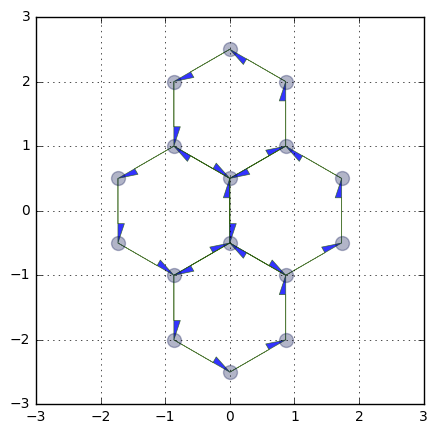

In [246]:
fig, ax = sheet_view(sheet)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
fig.set_size_inches((5, 5))

In [247]:
sheet.get_extra_indices()

KeyError: 'opposite'

In [ ]:
sheet.edge_df

In [ ]:
sheet.get_extra_indices()

In [ ]:
sheet.vert_df

In [ ]:
sheet.datasets['edge']['Myo'] = Meq
sheet.datasets['edge']['Rok'] = Req
sheet.datasets['edge']['Baz'] = Beq
sheet.datasets['edge']['Shroom'] = Seq

In [ ]:
sheet.datasets['edge'].head()

### Next: Define ODEs

#### Mechanical forces on vertices (total: 16 vertices):

$$ \frac{dx_{i}}{dt} = \frac{1}{\eta}\Bigg[\sum\limits_{j} f_{ij}\frac{{x_j}-{x_i}}{\left|x_j-x_i\right|} + f_{mi}e_{ci}+pe_{ni}\Bigg] $$

where $e_{ci}$ is a unit vector pointing from vertex $i$ toward the centroid of the cell and $e_{ni}$ is an outward normal vector that bisects the angle formed by the two edges meeting at vertex $i$.

$$ f_{ij} = \mu\big(l_{ij}-l_0\big)-\beta\big(m_{ij}-m^e\big) $$

$$ f_{mi} = \beta\Big[A_m\sin^2{\Big(\frac{t\pi}{T}+\phi\Big)}\Big] $$

#### Biochemistry on each edges (total: 19 edges):

$$ \frac{dm}{dt} = k_1R-k_2mB-(k_3 \exp^{-k_4f_{ij}})m $$

$$ \frac{dR}{dt}=q_r-k_re^{-S}R $$

$$ \frac{dB}{dt} = q_b - k_b RB $$

#### Order of equations:

- Movement x, 16 vertices
- Movement y, 16 vertices
- Rok, 19 edges
- Baz, 19 edges
- Myo, 19 edges

In [ ]:
# Build matrix of unknowns:

vert_x = sheet.datasets['vert']['x']
vert_y = sheet.datasets['vert']['y']
edge_Baz = sheet.datasets['edge']['Baz']
edge_Rok = sheet.datasets['edge']['Rok']
edge_Myo = sheet.datasets['edge']['Myo']

Y = pd.concat([vert_x, vert_y, edge_Baz, edge_Rok, edge_Myo], axis=0)


In [ ]:
print('Total ODEs: ')
len(Y)

In [ ]:
def diff_equations(vert_x,vert_y,edge_Baz,edge_Rok,edge_Myo):
    # vert_x_new = (1/eta)*[sum(f_ij*dir_Vec) + f_m*centroid_Vec + p*bisection_Vec]
    pass

In [ ]:
## 3-sheet example for comparison

from tyssue.geometry.sheet_geometry import SheetGeometry  as geom

datasets, specs = three_faces_sheet()
sheet3 = Sheet('3cells_2D', datasets, specs)

geom.update_all(sheet3)
fig, ax = sheet_view(sheet3, ['x', 'y'])

sheet3.datasets['edge']
sheet3.datasets['vert']

In [ ]:
sheet3.get_extra_indices()

Total Vertices:  42
Total Edges:  84


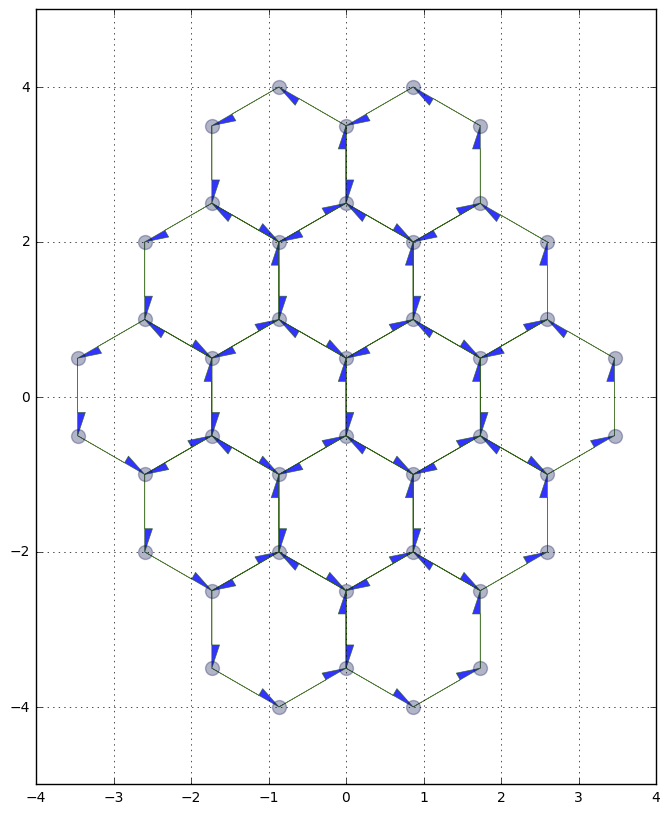

In [252]:
datasets, specs = multi_faces_sheet([2,3,4,3,2])
sheet14 = Sheet('14_cells', datasets, specs, coords=['x', 'y'])
MyGeometry.update_all(sheet14)
sheet14.sanitize()
fig, ax = sheet_view(sheet14)
fig.set_size_inches((10, 10))

Total Vertices:  64
Total Edges:  138


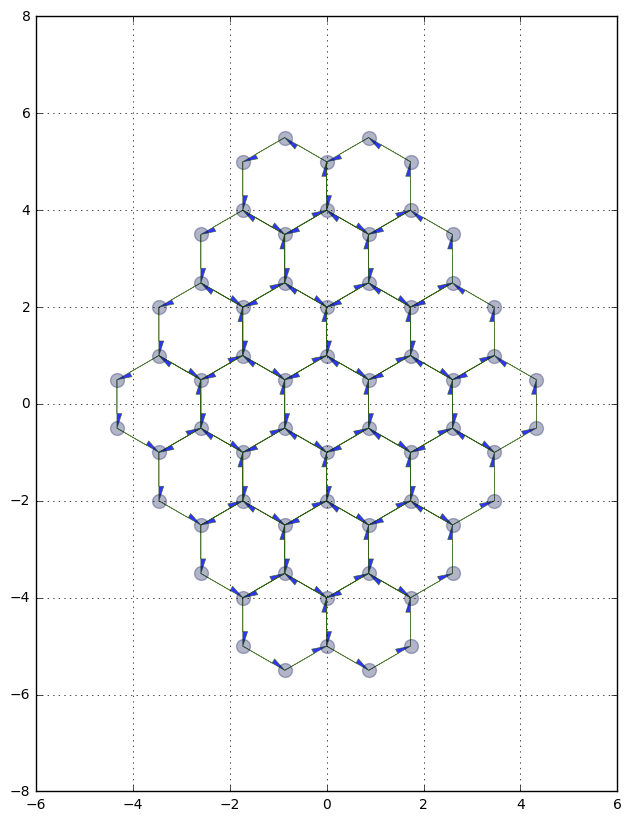

In [253]:
datasets, specs = multi_faces_sheet([2,3,4,5,4,3,2])
sheet = Sheet('more_cells', datasets, specs, coords=['x', 'y'])
MyGeometry.update_all(sheet)
sheet.sanitize()
fig, ax = sheet_view(sheet)
fig.set_size_inches((10, 10))

Total Vertices:  61
Total Edges:  126


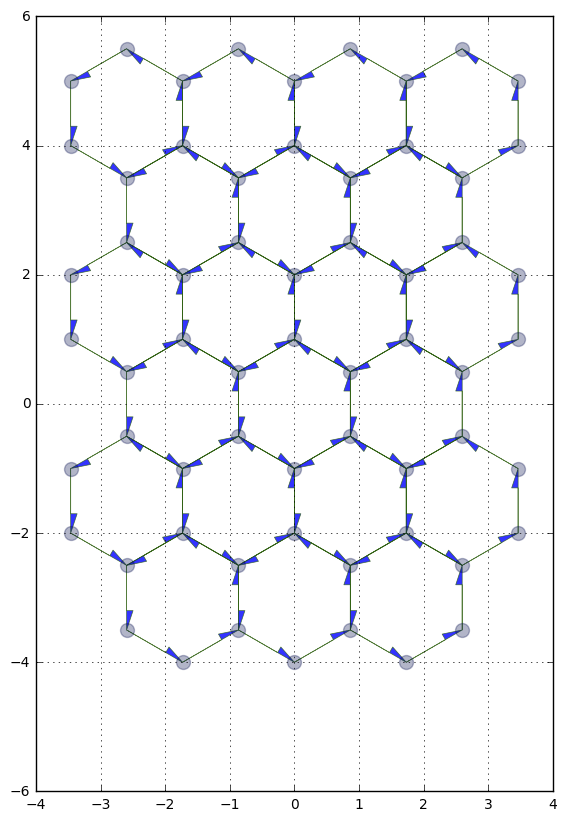

In [254]:
datasets, specs = multi_faces_sheet([4,3,4,3,4,3])
sheet = Sheet('more_cells', datasets, specs, coords=['x', 'y'])
MyGeometry.update_all(sheet)
sheet.sanitize()
fig, ax = sheet_view(sheet)
fig.set_size_inches((10, 10))